# Shallow Water Equation

## Load packages

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

## Solve the 1D SWE using the Finite Volume Method with a Riemann solver



In [66]:
def roe_solver(hL, huL, hR, huR, g=9.81):
    # Calculate Roe averages
    h_tilde = (hL + hR) / 2
    u_tilde = (np.sqrt(hL) * huL / hL + np.sqrt(hR) * huR / hR) / (np.sqrt(hL) + np.sqrt(hR))

    c = np.sqrt(g * h_tilde)

    # Calculate eigenvalues and eigenvectors
    lambda1 = u_tilde - c
    lambda2 = u_tilde + c
    R1 = np.array([1, lambda1])
    R2 = np.array([1, lambda2])

    # Compute wave strengths
    dh = hR - hL
    du = huR/hR - huL/hL
    alpha1 = 0.5*(dh - h_tilde/c * du)
    alpha2 = 0.5*(dh + h_tilde/c * du)

    # Compute fluxes
    F_L = np.array([huL, huL**2 / hL + 0.5 * g * hL**2])
    F_R = np.array([huR, huR**2 / hR + 0.5 * g * hR**2])

    # Compute the Roe flux
    F = 0.5 * (F_L + F_R) - 0.5 * (alpha1 * np.abs(lambda1) * R1 + alpha2 * np.abs(lambda2) * R2)
    return F

    
def compute_interface_fluxes(h, hu, N, g):
    fluxes = np.zeros((2, N+1))
    
    hL, huL = h[0], -hu[0]  
    hR, huR = h[1], hu[1]
    fluxes[:, 0] = roe_solver(hL, huL, hR, huR, g)
    
    for i in range(1, N):
        fluxes[:, i] = roe_solver(h[i-1], hu[i-1], h[i], hu[i], g)
    
    hL, huL = h[N-2], hu[N-2]
    hR, huR = h[N-1], -hu[N-1]

    fluxes[:, N] = roe_solver(hL, huL, hR, huR, g)
    
    return fluxes

def update_variables(h, hu, dt, fluxes, N, dx):
    h_new = h.copy()
    hu_new = hu.copy()
    
    for i in range(1, N-1):
        h_new[i] = h[i] - dt/dx * (fluxes[0, i+1] - fluxes[0, i])
        hu_new[i] = hu[i] - dt/dx * (fluxes[1, i+1] - fluxes[1, i])
        
    # Apply reflective boundary conditions
    h_new[0] = h_new[1]
    hu_new[0] = -hu_new[1]
    h_new[N-1] = h_new[N-2]
    hu_new[N-1] = -hu_new[N-2]
 
   
    return h_new, hu_new

# putting it all together
def solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81):
    # Store the intermediate states
    h_hist = []
    hu_hist = []
    dt_hist = []

    h_hist.append(h.copy())
    hu_hist.append(hu.copy())

    # Main loop
    while t < t_end:
        # Compute the time step
        u = hu/h
        c = np.sqrt(g*h)
        dt = CFL * dx/np.max(np.abs(u) + c)

        if t + dt > t_end:
            dt = t_end - t
        
        # Compute the fluxes at the interfaces
        fluxes = compute_interface_fluxes(h, hu, N, g)

        # Update the variables
        h, hu = update_variables(h, hu, dt, fluxes, N, dx)

        # Store the results
        h_hist.append(h.copy())
        hu_hist.append(hu.copy())
        dt_hist.append(dt)

        # Update the time
        t += dt

    n = len(dt_hist)

    print(f"Number of time steps: {n}")

    return h, hu, h_hist


### Suplot function

In [67]:
def subplot(h_hist, idx, L, N, save = False, filename = None):
    idx1, idx2, idx3 = idx
    y_max = max([h_hist[i].max() for i in idx]) + 0.1 # Determine the maximum y value among the selected indices
    y_min = min([h_hist[i].min() for i in idx]) - 0.1 # Determine the minimum y value among the selected indices

    plt.figure(figsize=(17, 5))

    plt.subplot(1, 3, 1)
    plt.plot(np.linspace(0, L, N), h_hist[idx1])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx1}/{len(h_hist) - 1}')
    plt.ylim(y_min, y_max)
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(np.linspace(0, L, N), h_hist[idx2])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx2}/{len(h_hist) - 1}')
    plt.ylim(y_min, y_max)
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(np.linspace(0, L, N), h_hist[idx3])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx3}/{len(h_hist) - 1}')
    plt.ylim(y_min, y_max)
    plt.grid()

    if save:
        plt.savefig(filename)

In [68]:
def subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/solution.png'):
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.plot(x,h_hist[0])
    plt.title('Initial water height')
    plt.xlabel('Distance (x)')
    plt.ylabel('Water height (h)')
    plt.grid()

    plt.subplot(1,4,2)  
    plt.plot(x,h)
    plt.title('Water height (h)')
    plt.xlabel('Distance (x)')
    #plt.ylabel('Water height (h)')
    plt.grid()

    plt.subplot(1,4,3)
    plt.plot(x,hu/h)
    plt.title('Velocity (u)')
    plt.xlabel('Distance (x)')
    #plt.ylabel('Velocity (u)')
    plt.grid()

    plt.subplot(1,4,4)
    plt.plot(x,hu)
    plt.title('Momentum (hu)')
    plt.xlabel('Distance (x)')
    #plt.ylabel('Momentum (hu)')
    plt.grid()

    if save:
        plt.savefig(filename)

    plt.show()  


## Dam break problem 1

Number of time steps: 135


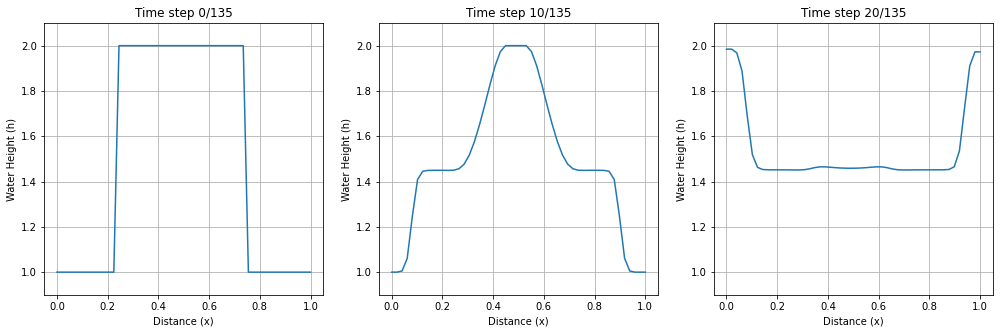

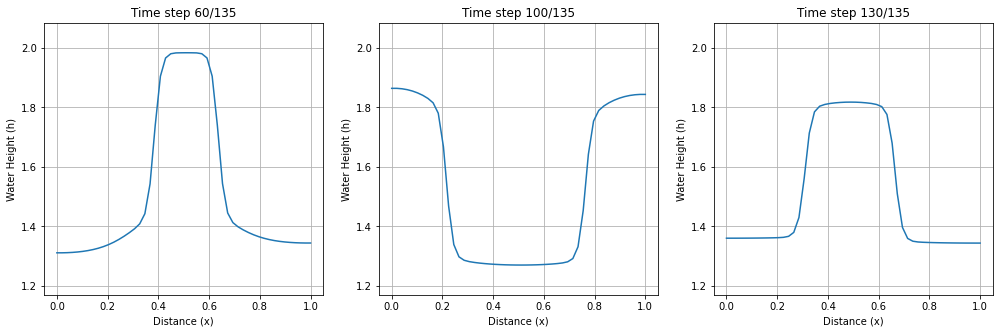

In [69]:
# Initialization
N = 50 # Number of grid points
L = 1 # Length of the domain

dx = L / N
x = np.linspace(0, L, N)

CFL = 0.9 # CFL number
g = 9.81 # Gravity

# Initial conditions
h = np.ones(N)
hu = np.zeros(N)
u = np.zeros(N)

h[int(N/4):int(3*N/4)] = 2.0  # higher water level in the middle

t = 0
t_end = 0.5

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81)

#subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/solution.png')
n = len(h_hist)
#idx = [0, int(n/2), n-1]
idx = [0, 10, 20]
subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter.png')
idx = [60, 100, 130]
subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter_2.png')


In [70]:
if 0:    
    fig, ax = plt.subplots(figsize=(10, 6))

    def update_plot(index):
        ax.clear()
        ax.plot(np.linspace(0, L, N), h_hist[index])
        ax.set_xlabel('Distance (x)')
        ax.set_ylabel('Water Height (h)')
        ax.set_title(f'Time step {index}/{len(h_hist) - 1}')
        ax.set_ylim(0, 2.1)  # Adjust this based on the expected range of water height
        ax.set_xlim(0, L)     # Ensure x-axis limits are consistent

    # Create animation
    ani = animation.FuncAnimation(fig, update_plot, frames=len(h_hist), interval=100)

    # Display the animation
    HTML(ani.to_jshtml())


In [71]:
#ani.save('animation_26062024_prob1.html', writer='html')
#dpi = 200
#ani.save('animation_26062024_prob1.gif', writer='pillow', dpi = dpi)

## Dam break problem 2

Number of time steps: 79


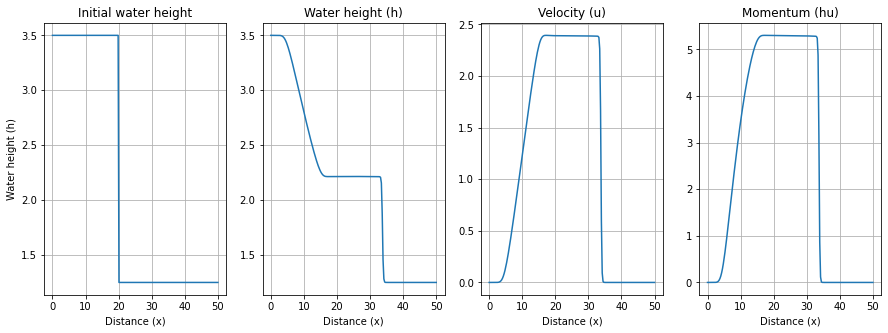

Number of time steps: 126


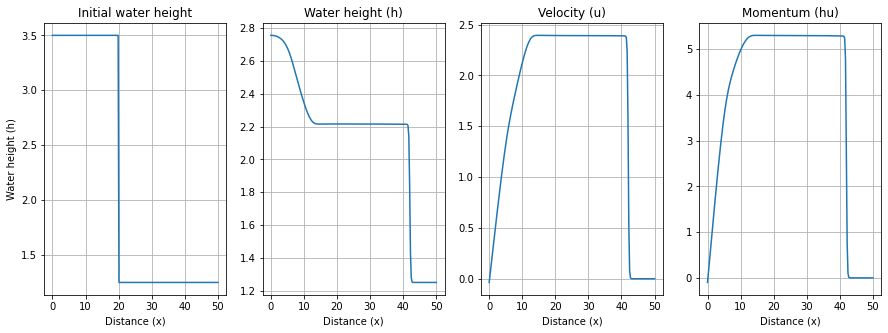

In [72]:
# Initialization
N = 200 # Number of grid points
L = 50 # Length of the domain
dx = L / N
x = np.linspace(0, L, N)

# Initial conditions
g = 9.81

hl = 3.5
hr = 1.25
h = np.where(x < 20, hl, hr)
hu = np.zeros(N)
u = np.zeros(N)

t = 0
t_end = 2.5

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81)

# Make 4 subplots
subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/sol_1D_val_no_limiter.png')


# Simulate up to t = 4
h = np.where(x < 20, hl, hr)
hu = np.zeros(N)
u = np.zeros(N)

t = 0
t_end = 4

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81)

# Make 4 subplots
subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/sol_1D_val_no_limiter.png')


In [73]:
if 0:    
    fig, ax = plt.subplots(figsize=(10, 6))

    def update_plot(index):
        ax.clear()
        ax.plot(np.linspace(0, L, N), h_hist[index])
        ax.set_xlabel('Distance (x)')
        ax.set_ylabel('Water Height (h)')
        ax.set_title(f'Time step {index}/{len(h_hist) - 1}')
        ax.set_ylim(0, 3.6)  # Adjust this based on the expected range of water height
        ax.set_xlim(0, L)     # Ensure x-axis limits are consistent
        ax.grid(True)
        
    # Create animation
    ani = animation.FuncAnimation(fig, update_plot, frames=len(h_hist), interval=100)

    # Display the animation
    HTML(ani.to_jshtml())


In [74]:
# Save animation as a gif
#ani.save('animation_26062024_prob2.html', writer='html')
#dpi = 200
#ani.save('animation_26062024_prob2.gif', writer='pillow', dpi = dpi)

## Solve the 2D SWE using FVM

In [75]:
def roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g=9.81):
    # Calculate Roe averages
    h_tilde = (hL + hR) / 2
    u_tilde = (np.sqrt(hL) * huL / hL + np.sqrt(hR) * huR / hR) / (np.sqrt(hL) + np.sqrt(hR))
    v_tilde = (np.sqrt(hL) * hvL / hL + np.sqrt(hR) * hvR / hR) / (np.sqrt(hL) + np.sqrt(hR))
    c = np.sqrt(g * h_tilde)

    # Calculate eigenvalues and eigenvectors
    lambda1 = u_tilde - c
    lambda2 = u_tilde
    lambda3 = u_tilde + c
    R1 = np.array([1, lambda1, v_tilde])
    R2 = np.array([0, 0, 1])
    R3 = np.array([1, lambda3, v_tilde])

    # Compute wave strengths
    du1 = hR - hL
    du2 = huR - huL
    du3 = hvR - hvL

    alpha1 = (du1 * lambda3 - du2) / (2 * c)
    alpha2 = du3 - v_tilde * du1
    alpha3 = (-du1 * lambda1 + du2) / (2 * c)

    # Compute F-fluxes
    F_L = np.array([huL, huL ** 2 / hL + 0.5 * g * hL ** 2, huL * hvL / hL])
    F_R = np.array([huR, huR ** 2 / hR + 0.5 * g * hR ** 2, huR * hvR / hR])

    # Compute the Roe flux
    F = 0.5 * (F_L + F_R) - 0.5 * (alpha1 * np.abs(lambda1) * R1 + alpha2 * np.abs(lambda2) * R2 + alpha3 * np.abs(lambda3) * R3)

    # Compute G-fluxes
    G_L = np.array([hvL, huL * hvL / hL, hvL ** 2 / hL + 0.5 * g * hL ** 2])
    G_R = np.array([hvR, huR * hvR / hR, hvR ** 2 / hR + 0.5 * g * hR ** 2])

    # Compute the Roe flux
    G = 0.5 * (G_L + G_R) - 0.5 * (alpha1 * np.abs(lambda1) * R1 + alpha2 * np.abs(lambda2) * R2 + alpha3 * np.abs(lambda3) * R3)

    return F, G

def compute_interface_fluxes_2D(h, hu, hv, N, g):
    fluxes_x = np.zeros((3, N+1, N))
    fluxes_y = np.zeros((3, N, N+1))

    # Compute x-direction fluxes
    for i in range(N):
        for j in range(N-1):
            hL, huL, hvL = h[i, j], hu[i, j], hv[i, j]
            hR, huR, hvR = h[i, j+1], hu[i, j+1], hv[i, j+1]
            fluxes_x[:, i, j+1], _ = roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g)

    # Compute y-direction fluxes
    for i in range(N-1):
        for j in range(N):
            hL, huL, hvL = h[i, j], hu[i, j], hv[i, j]
            hR, huR, hvR = h[i+1, j], hu[i+1, j], hv[i+1, j]
            _, fluxes_y[:, i+1, j] = roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g)

    return fluxes_x, fluxes_y

def update_variables_2D(h, hu, hv, dt, fluxes_x, fluxes_y, N, dx, dy):
    h_new = h.copy()
    hu_new = hu.copy()
    hv_new = hv.copy()

    for i in range(1, N-1):
        for j in range(1, N-1):
            h_new[i, j] = h[i, j] - dt/dx * (fluxes_x[0, i, j+1] - fluxes_x[0, i, j]) - dt/dy * (fluxes_y[0, i+1, j] - fluxes_y[0, i, j])
            hu_new[i, j] = hu[i, j] - dt/dx * (fluxes_x[1, i, j+1] - fluxes_x[1, i, j]) - dt/dy * (fluxes_y[1, i+1, j] - fluxes_y[1, i, j])
            hv_new[i, j] = hv[i, j] - dt/dx * (fluxes_x[2, i, j+1] - fluxes_x[2, i, j]) - dt/dy * (fluxes_y[2, i+1, j] - fluxes_y[2, i, j])

    # Apply reflective boundary conditions
    h_new[0, :] = h_new[1, :]
    hu_new[0, :] = -hu_new[1, :]
    hv_new[0, :] = -hv_new[1, :]
    h_new[:, 0] = h_new[:, 1]
    hu_new[:, 0] = -hu_new[:, 1]
    hv_new[:, 0] = -hv_new[:, 1]
    h_new[N-1, :] = h_new[N-2, :]
    hu_new[N-1, :] = -hu_new[N-2, :]
    hv_new[N-1, :] = -hv_new[N-2, :]
    h_new[:, N-1] = h_new[:, N-2]
    hu_new[:, N-1] = -hu_new[:, N-2]
    hv_new[:, N-1] = -hv_new[:, N-2]
    
    return h_new, hu_new, hv_new

def solve_SWE_2D(t, t_end, h, hu, hv, N, dx, dy, CFL=0.9, g=9.81):
    # Store the intermediate states
    h_hist = []
    hu_hist = []
    hv_hist = []
    dt_hist = []

    h_hist.append(h.copy())
    hu_hist.append(hu.copy())
    hv_hist.append(hv.copy())

    # Main loop
    while t < t_end:
        # Compute the time step
        u = hu/h
        v = hv/h
        c = np.sqrt(g*h)
        dt = CFL * min(dx, dy) / np.max(np.abs(u) + np.abs(v) + c)

        if t + dt > t_end:
            dt = t_end - t

        # Compute the fluxes at the interfaces
        fluxes_x, fluxes_y = compute_interface_fluxes_2D(h, hu, hv, N, g)

        # Update the variables
        h, hu, hv = update_variables_2D(h, hu, hv, dt, fluxes_x, fluxes_y, N, dx, dy)

        # Store the results
        h_hist.append(h.copy())
        hu_hist.append(hu.copy())
        hv_hist.append(h.copy())
        dt_hist.append(dt)

        # Update the time
        t += dt

    n = len(dt_hist)
    print(f"Number of time steps: {n}")

    return h, hu, hv, h_hist, dt_hist



In [76]:
# Initialization
N = 20 # Number of grid points
L = 1 # Length of the domain
dx = L / N
dy = L / N

x = np.linspace(0, L, N)
y = np.linspace(0, L, N)

CFL = 0.9 # CFL number
g = 9.81 # Gravity

t = 0
t_end = 0.5

# Initial conditions
h = np.ones((N, N))
hu = np.zeros((N, N))
hv = np.zeros((N, N))

# Set the initial water height (dam break problem)
h[:int(N/2), :int(N/2)] = 2.0  # higher water level in the corner

# Solve the problem
h, hu, hv, h_hist, dt_hist = solve_SWE_2D(t, t_end, h, hu, hv, N, dx, dy, CFL=0.9, g=9.81)

Number of time steps: 77


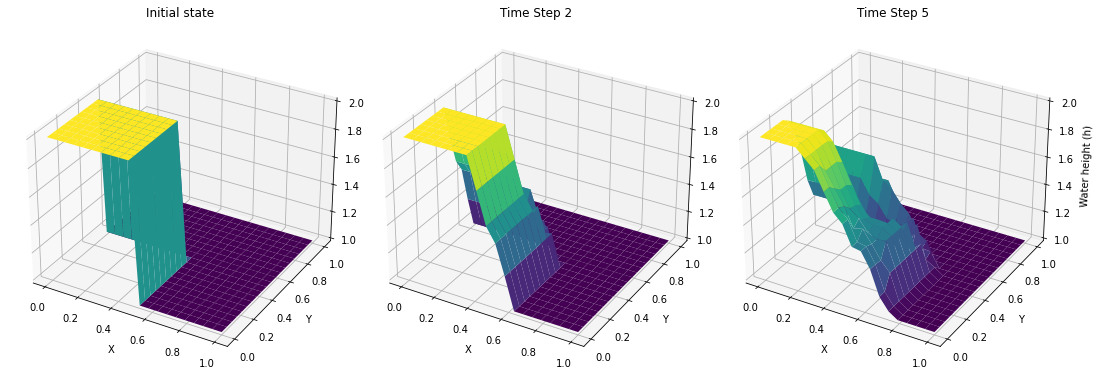

In [77]:
# Define the grid
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
X, Y = np.meshgrid(x, y)

idx = [0, 2, 5]

# Plot h at different time steps
fig = plt.figure(figsize=(15, 9))

# Initial state
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, Y, h_hist[0], cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Water height (h)')
ax1.set_title('Initial state')

# Middle state
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, Y, h_hist[idx[1]], cmap='viridis')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Water height (h)')
ax2.set_title(f'Time Step {idx[1]}')

# Final state
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X, Y, h_hist[idx[2]], cmap='viridis')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Water height (h)')
ax3.set_title(f'Time Step {idx[2]}')

plt.tight_layout()
plt.show()
